## NYC Open Data Common Column Names 
#### Exploratory Data Analysis of field names
Hack day Q2 2020

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
plt.rcParams['axes.xmargin'] = 0

In [35]:
common_columns_df = pd.read_csv("nyc_columns_common.csv", index_col=0)
common_columns_df.head()

,name,field_type,field_name,description,dataset-id,dataset_link,portal
6,DOBRunDate,Calendar date,dobrundate,Date when query is run and pushed to Open Data...,ic3t-wcy2,https://data.cityofnewyork.us/d/ic3t-wcy2,data.cityofnewyork
7,Zip,Text,zip,Zip,ic3t-wcy2,https://data.cityofnewyork.us/d/ic3t-wcy2,data.cityofnewyork
8,State,Text,state,State,ic3t-wcy2,https://data.cityofnewyork.us/d/ic3t-wcy2,data.cityofnewyork
10,Owner Type,Text,owner_type,Owner Type,ic3t-wcy2,https://data.cityofnewyork.us/d/ic3t-wcy2,data.cityofnewyork
34,Owner's Last Name,Text,owner_s_last_name,Last Name of property owner,ic3t-wcy2,https://data.cityofnewyork.us/d/ic3t-wcy2,data.cityofnewyork


In [36]:
common_columns_df.describe()

,name,field_type,field_name,description,dataset-id,dataset_link,portal
count,25845,25845,25845,4138,25845,25845,25845
unique,2410,17,1415,2155,2024,2024,1
top,Borough,Text,borough,One of the five boroughs of New York City. NY...,expp-gbrz,https://data.cityofnewyork.us/d/expp-gbrz,data.cityofnewyork
freq,504,11885,592,28,79,79,25845


### Visualize most common field names

In [38]:
field_name_counts = common_columns_df.field_name.value_counts()

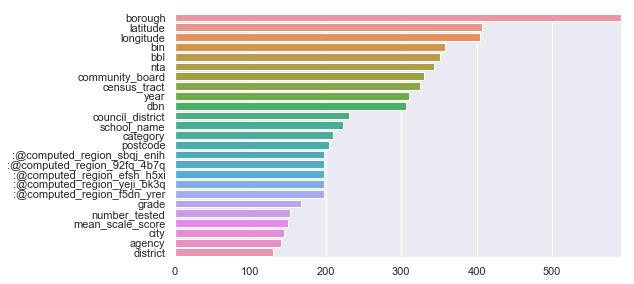

In [40]:
# Plotting headcount
n = 25

fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
sns.barplot(x=field_name_counts.iloc[:n].values, y=field_name_counts.iloc[:n].index, ax=ax);

### Visualize most common human-readable names

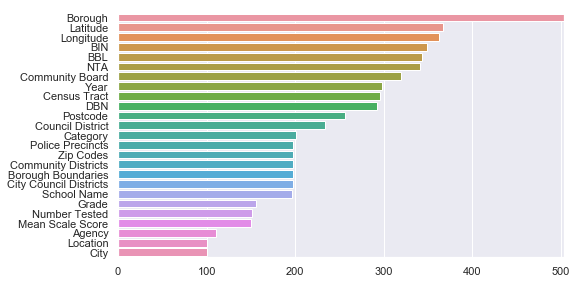

In [42]:
name_counts = common_columns_df.name.value_counts()
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
sns.barplot(x=name_counts.iloc[:25].values, y=name_counts.iloc[:n].index, ax=ax);

### What does the `field_name` -> `name` mapping look like?  

Overall, the vast majority of field names map to one or two human-readable names.

In [49]:
values_per_field_name = (common_columns_df
                         .groupby('field_name')
                         .nunique()
                         .drop(columns='field_name')
                         .sort_values(by='name', ascending=False))

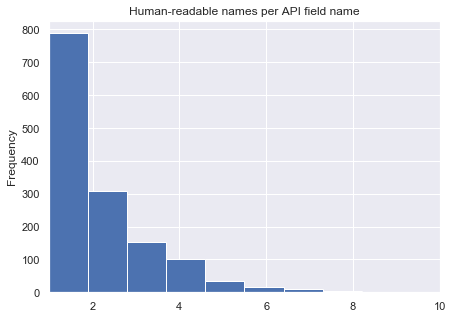

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
values_per_field_name.name.plot.hist(ax=ax, title="Human-readable names per API field name");

#### Let's have a look at the worst offenders
It appears that most of these could be cleared up with simple cleaning or fuzzy string matching, with the exception of `council_district` -> `Community Board`, `council_district` -> `council`, and `zip_code` -> `Postcode` (and similar).

In [51]:
values_per_field_name.iloc[:10]

,name,field_type,description,dataset-id,dataset_link,portal
field_name,,,,,,
zip_code,10,5,24,78,78,1
council_district,9,4,33,231,231,1
zipcode,8,4,23,52,52,1
geocoded_column,8,2,3,38,38,1
boro,8,4,22,98,98,1
address,8,2,37,108,108,1
type,8,3,23,50,50,1
name,7,2,29,87,87,1
state,7,2,27,105,105,1


In [52]:
worst_field_names = values_per_field_name[values_per_field_name['name'] >= 9].index.tolist()
worst_field_names

['zip_code', 'council_district']

In [53]:
name_and_field_name_pairs = common_columns_df.groupby(['field_name', 'name']).size().reset_index().rename(columns={0 : 'count'})
name_and_field_name_pairs[name_and_field_name_pairs['field_name'].isin(worst_field_names)]

,field_name,name,count
673,council_district,COUNCIL DISTRICT,17
674,council_district,COUNCIL_DISTRICT,13
675,council_district,Community Board,1
676,council_district,Council District,193
677,council_district,Council District,1
678,council_district,Council-district,1
679,council_district,council,1
680,council_district,council district,2
681,council_district,council_district,2
2637,zip_code,EventZipCode,3


### Investigate the distribution of field types
We should (probably?) only match field names if for columns with the same field type

In [9]:
common_columns_df.field_type.value_counts()

Text             11885
Number            7388
text              3262
number            2568
Calendar date      296
Point              179
calendar_date      136
point               62
Checkbox            18
URL                 13
date                12
MultiPolygon        11
Date                10
MultiLine            2
checkbox             1
multipolygon         1
url                  1
Name: field_type, dtype: int64

In [56]:
# Based on the above, I would recommend the following mapping to identify similar field types
def clean_field_types(column):
    new_column = column.str.lower().str.replace('_', ' ')
    return new_column.replace('calendar date', 'date')

common_columns_df.field_type = clean_field_types(common_columns_df.field_type)

In [57]:
common_columns_df.field_type.value_counts()

text            15147
number           9956
date              454
point             241
checkbox           19
url                14
multipolygon       12
multiline           2
Name: field_type, dtype: int64

### Let's investigate columns with field_type=date
There are 62 different `field_name` values with `field_type=date`. At first glance, it seems like these could be mapped to a smaller set of around 30 unique `field_name` values using some combination of fuzzy string matching or a simple NLP. From there, Scout could potentially filter datasets which have a matching datetime column and some overlapping time series within those columns.

In [71]:
# Most common field names
date_columns_df = common_columns_df[common_columns_df['field_type'] == 'date'].copy()
date_column_counts = date_columns_df.field_name.value_counts()
len(date_column_counts)

62

The main thing I notice here is that we need a simple text matching for things like `closed_date` <--> `date_closed`. The problem I foresee running into is that with some of the less-common columns like `event_date` we can try to map it onto something more common, but we don't know what other columns are in the dataset(s) along with it so we can't guarantee an injective mapping onto the column names and could end up with duplicates. 

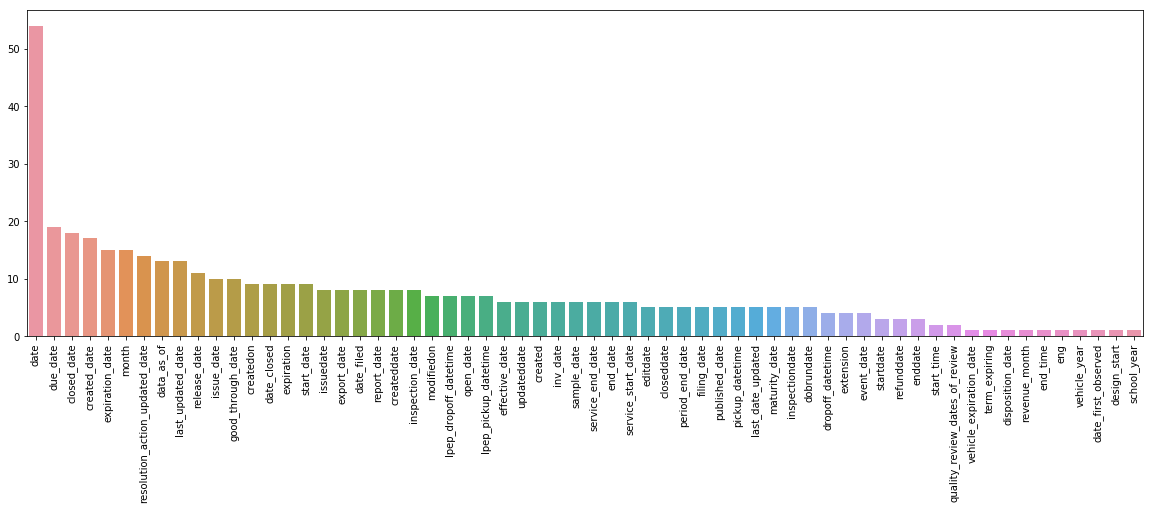

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(x=date_column_counts.index, y=date_column_counts.values)
plt.xticks(rotation=90);

### How reliable are the field types when it comes to datetime categories?
Here we see that 48 dataframes have column with the words "date" or "time' that is categorized as some other field. If included in the `type=date`, this would comprise about 10% of the data so it may be important to identify all columns with the words "date" or "time" as potential datetime columns. I am not sure about the one called `date_status`.

In [65]:
other_types_df = common_columns_df[common_columns_df['field_type'] != 'date']
other_types_df_with_datetime = other_types_df[other_types_df.field_name.str.match('date|time')]

print(len(other_types_df_with_datetime))
other_types_df_with_datetime.groupby(['field_type', 'field_name']).size().reset_index()

48


,field_type,field_name,0
0,number,date_first_observed,6
1,text,date,20
2,text,date_status,5
3,text,time,10
4,text,time_first_observed,7


Add `field_name` values with `field_type = number, text` to the date column dataframe. Thankfully, this only adds 3 new `field_name` values into the mix.

In [74]:
date_columns_df = pd.concat((date_columns_df, other_types_df_with_datetime))
len(date_columns_df.field_name.unique())

65